### 專案名稱: 第四屆機器學習百日馬拉松
### 功能描述: 第85天作業
### 版權所有: Dunk  
### 程式撰寫: Dunk  
### 撰寫日期：2020/06/16
### 改版日期:  
### 改版備註:

## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

### ANS:

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCE = [10, 25]

In [7]:
# 載入 Callbacks並記錄過程
from keras.callbacks import EarlyStopping
results = {}
for pat in PATIENCE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape[1:])
    print("Experiment with PATIENCE = %s" % (pat))
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    earlystop = EarlyStopping(monitor="val_accuracy", 
                          patience=pat, 
                          verbose=1
                          )# 載入 Callbacks, 並將 monitor 設定為監控 Validation Accuracy
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-PATIENCE-%s" % (str(pat))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with PATIENCE = 10
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 15s 292us/step - loss: 2.2314 - accuracy: 0.2681 - val_loss: 2.1434 - val_accuracy: 0.2404
Epoch 2/50
50000/50000 [==============================] - 12s 247us/step - loss: 1.7433 - accuracy: 0.3932 - val_loss: 1.9807 - val_accuracy: 0.2973
Epoch 3/50
50000/50000 [==============================] - 12s 245us/step - loss: 1.6152 - accuracy: 0.4328 - val_loss: 1.8330 - val_accuracy: 0.3622
Epoch 4/50
50000/50000 [==============================] - 13s 251us/step - loss: 1.5438 - accuracy: 0.4580 - val_loss: 1.7129 - val_accuracy: 0.4059
Epoch 5/50
50000/50000 [==============================] - 13s 251us/step - loss: 1.4896 - accuracy: 0.4769 - val_loss: 1.6429 - val_accuracy: 0.4239
Epoch 6/50
50000/50000 [==============================] - 12s 245us/step - loss: 1.4464 - accuracy: 0.4929 - val_loss: 1.5793 - val_accuracy: 0.4459
Epoch 7/50
50000/50000 [==============================] 

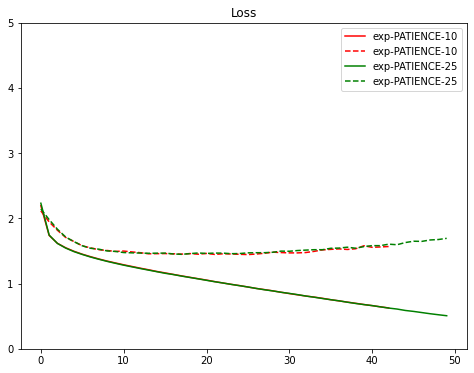

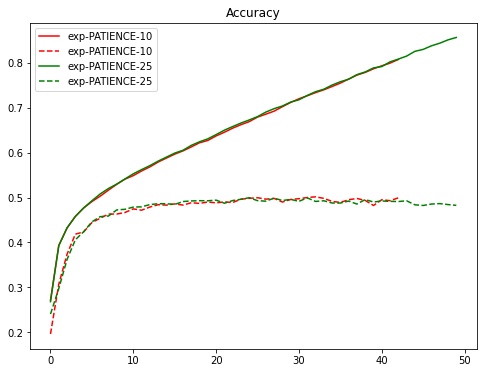

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
# color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()